In [8]:
import pandas as pd
import os

data_path = "..\\Dataset\\split_01.csv"

df = pd.read_csv(data_path)
print(df.head())

                              legId  searchDate  flightDate startingAirport  \
0  cc7ca757dcd0ff76b2f0b4eb37419886  2022-04-16  2022-04-17             ATL   
1  398e2cd3e08b555a1f8c2113824474ca  2022-04-16  2022-04-17             ATL   
2  12ace2050ae312b0223484a949eaf227  2022-04-16  2022-04-17             ATL   
3  1122006b99c9a15118b2e469815555db  2022-04-16  2022-04-17             ATL   
4  97a100c46442e1d44b9a347e07124f01  2022-04-16  2022-04-17             ATL   

  destinationAirport fareBasisCode travelDuration  elapsedDays  \
0                CLT      QAA0JHES        PT5H52M            0   
1                DTW      L0AIZNN1        PT3H46M            0   
2                DTW      KA0NX0MC        PT8H45M            1   
3                DTW      QA0NA0MC         PT8H9M            1   
4                DTW      MA0QA0MQ        PT5H12M            0   

   isBasicEconomy  isRefundable  ...  segmentsArrivalTimeEpochSeconds  \
0           False         False  ...           16502404

# (i) Dataset preprocessing


## **Task: Consider only non-stop flights for this part. You have to create a new dataset listing the distance, duration, airline, and airplane type for all non-stop flights. Add a new column called " speed ," which is calculated by dividing the distance by the duration.**

In [9]:
df.columns

Index(['legId', 'searchDate', 'flightDate', 'startingAirport',
       'destinationAirport', 'fareBasisCode', 'travelDuration', 'elapsedDays',
       'isBasicEconomy', 'isRefundable', 'isNonStop', 'baseFare', 'totalFare',
       'seatsRemaining', 'totalTravelDistance',
       'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw',
       'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalTimeRaw',
       'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode',
       'segmentsAirlineName', 'segmentsAirlineCode',
       'segmentsEquipmentDescription', 'segmentsDurationInSeconds',
       'segmentsDistance', 'segmentsCabinCode'],
      dtype='object')

Let us first drop all the rows whose data is not available for the fields that we are supposed to work on, that is NaN or null

In [10]:
filtered_df = df[df['isNonStop'] == True]

# Selecting the specified columns
selected_columns_df = filtered_df[['travelDuration', 'totalTravelDistance', 'segmentsAirlineName', 'segmentsEquipmentDescription']]

print(selected_columns_df.head())

   travelDuration  totalTravelDistance segmentsAirlineName  \
5         PT2H11M                762.0               Delta   
9            PT5H               1943.0               Delta   
13        PT1H55M                596.0   Frontier Airlines   
15         PT2H6M                600.0               Delta   
16        PT2H15M                600.0   American Airlines   

   segmentsEquipmentDescription  
5                   Airbus A320  
9                Boeing 757-300  
13                          NaN  
15                  Airbus A321  
16                  Embraer 175  


In [11]:
print("Length before dropping rows:", len(selected_columns_df))
selected_columns_df.dropna(inplace=True)
print("Length after dropping rows:", len(selected_columns_df))

Length before dropping rows: 1103397
Length after dropping rows: 996418


C:\Users\kmakadia\AppData\Local\Temp\ipykernel_16592\3765449914.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_columns_df.dropna(inplace=True)


Parsing the duration into a numerical value

In [12]:
import pandas as pd
import re

# Function to parse the travel duration string and convert it to hours
# The function assumes the format is 'PTXHYM' where X is hours and Y is minutes
def parse_duration(duration_str):
    if pd.isna(duration_str):
        return None
    match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?', duration_str)
    if match:
        hours = int(match.group(1)) if match.group(1) else 0
        minutes = int(match.group(2)) if match.group(2) else 0
        return hours + minutes / 60
    return None

selected_columns_df = filtered_df[['travelDuration', 'totalTravelDistance', 'segmentsAirlineName',
                                   'segmentsEquipmentDescription']].copy()

selected_columns_df['travelDuration_hours'] = selected_columns_df['travelDuration'].apply(parse_duration)
print(selected_columns_df.head())


   travelDuration  totalTravelDistance segmentsAirlineName  \
5         PT2H11M                762.0               Delta   
9            PT5H               1943.0               Delta   
13        PT1H55M                596.0   Frontier Airlines   
15         PT2H6M                600.0               Delta   
16        PT2H15M                600.0   American Airlines   

   segmentsEquipmentDescription  travelDuration_hours  
5                   Airbus A320              2.183333  
9                Boeing 757-300              5.000000  
13                          NaN              1.916667  
15                  Airbus A321              2.100000  
16                  Embraer 175              2.250000  


Adding new column "speed" ( shows speed in miles/hr )

In [13]:
selected_columns_df.loc[:, 'speed'] = selected_columns_df['totalTravelDistance'] / selected_columns_df['travelDuration_hours']
print(selected_columns_df.head())

   travelDuration  totalTravelDistance segmentsAirlineName  \
5         PT2H11M                762.0               Delta   
9            PT5H               1943.0               Delta   
13        PT1H55M                596.0   Frontier Airlines   
15         PT2H6M                600.0               Delta   
16        PT2H15M                600.0   American Airlines   

   segmentsEquipmentDescription  travelDuration_hours       speed  
5                   Airbus A320              2.183333  349.007634  
9                Boeing 757-300              5.000000  388.600000  
13                          NaN              1.916667  310.956522  
15                  Airbus A321              2.100000  285.714286  
16                  Embraer 175              2.250000  266.666667  


## **Task:Many rows in your new dataset will be exactly identical. What should you do with them? Your goal in this part of the project is to check if there are differences in flight speeds across airplane types, airlines, and routes. Should you count repeated rows only once, or as many times as they appear? What if two rows are almost identical (e.g., two rows with the same airline, airplane, and route but slightly different durations or distances)? Should you use one, both, or their average? Make a choice and explain it.**

We first remove all exact duplicate rows from the dataset to eliminate redundant entries that provide no new information. Keeping such duplicates can artificially inflate the dataset, leading to biased statistical outcomes and an overrepresentation of certain flights. Additionally, we can also identify rows that share the same airline name and airplane type but differ slightly in distance and duration. These can be aggregated by averaging their speed, distance, and duration values. This approach helps reduce noise caused by minor real-world variations (such as weather or routing differences) and ensures a more accurate and representative analysis of typical flight speeds across different airlines and aircraft types.

In [14]:
import pandas as pd
import numpy as np

# Step 1: We remove the exact duplicates
selected_columns_df_unique = selected_columns_df.drop_duplicates()

# Step 2: Now, I manually defined "slight variation" thresholds, these are based on my understanding of "slight variation" and can be subjective.
# You can adjust these thresholds based on your understanding of the data and what constitutes a "slight variation".
DISTANCE_THRESHOLD = 50     # miles
DURATION_THRESHOLD = 0.25   # hours (15 minutes)

# Step 3: Now, I have sorted the data for stable grouping
selected_columns_df_unique = selected_columns_df_unique.sort_values(
    by=['segmentsAirlineName', 'segmentsEquipmentDescription', 'totalTravelDistance', 'travelDuration_hours']
).reset_index(drop=True)

# Step 4: Updating speeds with average speed for similar rows
updated_speeds = selected_columns_df_unique['speed'].copy()
visited = set()

for i in range(len(selected_columns_df_unique)):
    if i in visited:
        continue

    row = selected_columns_df_unique.iloc[i]

    # Find similar rows (same airline + aircraft type, and similar distance OR duration)
    similar_mask = (
        (selected_columns_df_unique['segmentsAirlineName'] == row['segmentsAirlineName']) &
        (selected_columns_df_unique['segmentsEquipmentDescription'] == row['segmentsEquipmentDescription']) &
        (
            (np.abs(selected_columns_df_unique['totalTravelDistance'] - row['totalTravelDistance']) <= DISTANCE_THRESHOLD) |
            (np.abs(selected_columns_df_unique['travelDuration_hours'] - row['travelDuration_hours']) <= DURATION_THRESHOLD)
        )
    )

    similar_indices = selected_columns_df_unique[similar_mask].index
    avg_speed = selected_columns_df_unique.loc[similar_indices, 'speed'].mean()

    # Set the average speed for all similar rows
    updated_speeds.loc[similar_indices] = avg_speed

    visited.update(similar_indices)

# Step 5: Assign smoothed speed values back to the DataFrame
selected_columns_df_unique['speed'] = updated_speeds

print(selected_columns_df_unique.head())
print(f"Total rows after smoothing: {len(selected_columns_df_unique)}")


  travelDuration  totalTravelDistance segmentsAirlineName  \
0        PT1H24M                339.0     Alaska Airlines   
1        PT1H25M                339.0     Alaska Airlines   
2        PT1H30M                339.0     Alaska Airlines   
3        PT3H34M               1468.0     Alaska Airlines   
4        PT3H50M               1468.0     Alaska Airlines   

      segmentsEquipmentDescription  travelDuration_hours       speed  
0  AIRBUS INDUSTRIE A321 SHARKLETS              1.400000  235.812325  
1  AIRBUS INDUSTRIE A321 SHARKLETS              1.416667  235.812325  
2  AIRBUS INDUSTRIE A321 SHARKLETS              1.500000  235.812325  
3  AIRBUS INDUSTRIE A321 SHARKLETS              3.566667  397.272653  
4  AIRBUS INDUSTRIE A321 SHARKLETS              3.833333  397.272653  
Total rows after smoothing: 18682


In [15]:
# Constructing the output file path, better to save the output than to re-run the code
preprocessed_data_path = "..\\Dataset\\preprocessed_data_part_a.csv"

# Save the DataFrame to CSV
selected_columns_df_unique.to_csv(preprocessed_data_path, index=False)

print(f"Saved preprocessed data to: {preprocessed_data_path}")

Saved preprocessed data to: ..\Dataset\preprocessed_data_part_a.csv


## **Task: Since the dataset is very large you should choose at what stage of the analysis you should handle repetitions to keep the analysis tractable.**

To keep the analysis manageable with such a large dataset, it's best to handle repetitions early in the process, right after filtering and cleaning the necessary columns. Removing exact duplicates and averaging near-duplicate rows at this stage reduces the dataset size and prevents unnecessary repetition from affecting the results. This makes later steps like grouping, plotting, and statistical testing faster and more accurate.

# (ii) Examine the probability distribution of speeds.

## **Task : Plot a histogram of the speeds. Comment on it.**

The distribution of flight speeds in the dataset reveals several distinct patterns. While most commercial flights operate between 300 and 450 miles per hour — consistent with typical jet cruising speeds — there are noticeable peaks in the distribution suggesting the presence of multiple operational regimes, possibly reflecting different aircraft types or route distances. A small number of flights exhibit significantly lower average speeds, likely representing short-haul or regional operations where non-cruise phases (like taxiing) comprise a larger portion of the journey. The KDE curve further confirms the
multimodal nature of the dataset, indicating that flight speed is not uniformly distributed but varies systematically across segments.

In [16]:
import pandas as pd
preprocessed_data_path = "..\\Dataset\\preprocessed_data_part_a.csv"

# preprocessed_data_path ="/content/preprocessed_data_part_a.txt"

preprocessed_df = pd.read_csv(preprocessed_data_path)
print("Successfully read preprocessed data.")
print(preprocessed_df.head())

Successfully read preprocessed data.
  travelDuration  totalTravelDistance segmentsAirlineName  \
0        PT1H24M                339.0     Alaska Airlines   
1        PT1H25M                339.0     Alaska Airlines   
2        PT1H30M                339.0     Alaska Airlines   
3        PT3H34M               1468.0     Alaska Airlines   
4        PT3H50M               1468.0     Alaska Airlines   

      segmentsEquipmentDescription  travelDuration_hours       speed  
0  AIRBUS INDUSTRIE A321 SHARKLETS              1.400000  235.812325  
1  AIRBUS INDUSTRIE A321 SHARKLETS              1.416667  235.812325  
2  AIRBUS INDUSTRIE A321 SHARKLETS              1.500000  235.812325  
3  AIRBUS INDUSTRIE A321 SHARKLETS              3.566667  397.272653  
4  AIRBUS INDUSTRIE A321 SHARKLETS              3.833333  397.272653  


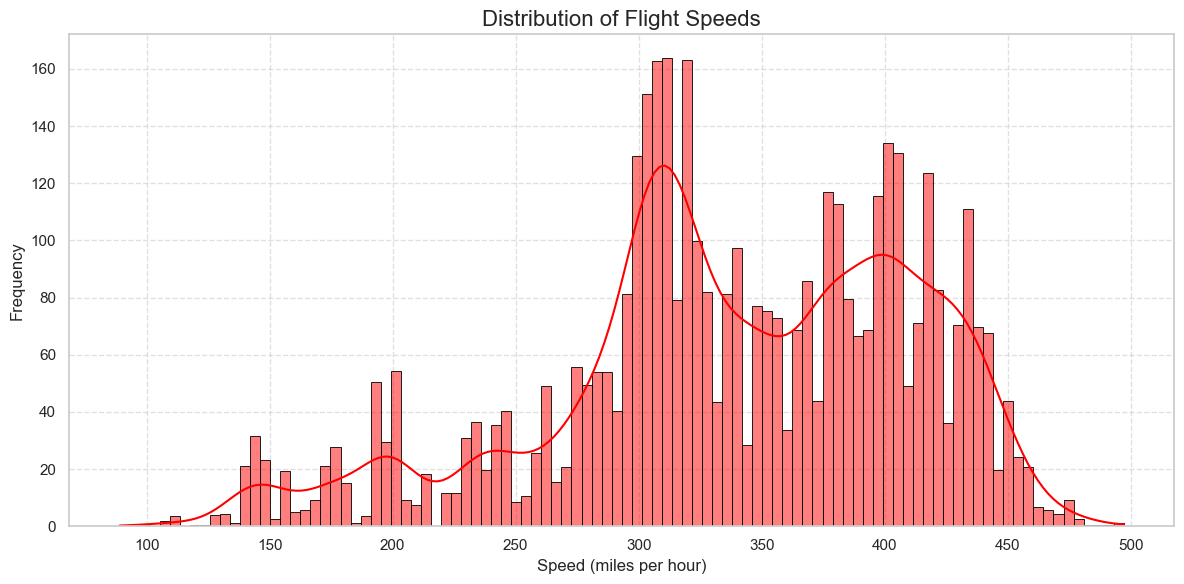

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 6))
sns.histplot(preprocessed_df['speed'], bins=100, kde=True, color='red', edgecolor='black', stat='frequency')

# Titles and labels
plt.title('Distribution of Flight Speeds', fontsize=16)
plt.xlabel('Speed (miles per hour)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Grid and layout
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

## **Task : Filter out the speeds for the airplane type Boeing 737-800. Do a K-S test to check whether it is normal with the sample mean and sample variance as the parameters of the Normal. Choose a threshold value of 0.05. Do the same for the speeds for airline Delta.**

In [18]:
from scipy.stats import norm
from math import sqrt, exp
import numpy as np

def one_sample_ks_fixed(sample):

    sample = np.sort(np.array(sample))
    n = len(sample)
    mean = np.mean(sample)
    std = np.std(sample)

    unique_vals = np.unique(sample)
    d_stat = 0.0

    for val in unique_vals: #dealing with repeated values
        ecdf_minus = np.sum(sample < val) / n
        ecdf_plus = np.sum(sample <= val) / n
        cdf = norm.cdf(val, loc=mean, scale=std)

        diff1 = abs(cdf - ecdf_minus)
        diff2 = abs(ecdf_plus - cdf)
        d_stat = max(d_stat, diff1, diff2)

    return d_stat

### Boeing 737-800

In [19]:
# thershold value
c = 0.05

# --------- Boeing 737-800 ----------
boeing_df = preprocessed_df[preprocessed_df['segmentsEquipmentDescription'] == 'Boeing 737-800']
boeing_speeds = np.array(boeing_df['speed'])


d = one_sample_ks_fixed(boeing_speeds)

print("=== K-S Test: Boeing 737-800 ===")
print()
print(f"KS Statistic: {d:.4f}")
print("Given Threshold: ",c)
if d > c:
    print("Result: Reject the null hypothesis → Speed is NOT normally distributed.")
else:
    print("Result: Fail to reject the null hypothesis → Speed MAY be normally distributed.")

=== K-S Test: Boeing 737-800 ===

KS Statistic: 0.0968
Given Threshold:  0.05
Result: Reject the null hypothesis → Speed is NOT normally distributed.


### Delta Airlines

In [20]:
# thershold value
c = 0.05

# --------- Delta Airlines ----------

delta_df = preprocessed_df[preprocessed_df['segmentsAirlineName'] == 'Delta']
delta_speeds = np.array(delta_df['speed'])

d = one_sample_ks_fixed(delta_speeds)

print("=== K-S Test: Delta Airlines ===")
print()
print(f"KS Statistic: {d:.4f}")
print("Given Threshold: ",c)
if d>c:
    print("Result: Reject the null hypothesis → Speed is NOT normally distributed.")
else:
    print("Result: Fail to reject the null hypothesis → Speed MAY be normally distributed.")

=== K-S Test: Delta Airlines ===

KS Statistic: 0.0000
Given Threshold:  0.05
Result: Fail to reject the null hypothesis → Speed MAY be normally distributed.


## **Task: Using the 2-sample K-S test and the Permutation test check if the probability distributions of speeds for the Boeing 737-800 and Boeing 737-900 airplanes differ or are same. Do the same for the Delta vs American Airlines flights.**

In [ ]:
def two_sample_ks_test(x, y):

    x = np.array(x)
    y = np.array(y)

    # Ensure x is the smaller array
    if len(x) > len(y):
        x, y = y, x

    sorted_x = np.sort(x)
    sorted_y = np.sort(y)

    n = len(sorted_x)
    m = len(sorted_y)
    d_stat = 0.0

    for i in range(n):
        e = sorted_x[i]

        # ECDF for x
        x_minus = i / n
        x_plus = (i + 1) / n

        # ECDF for y
        y_indices = np.where(sorted_y == e)[0]

        if len(y_indices) > 0:

            #If element is in y, calculate plus and minus values separately
            first_idx = y_indices[0]
            last_idx = y_indices[-1]

            y_minus = first_idx / m
            y_plus = (last_idx + 1) / m
        else:     
            less_than_e = sorted_y[sorted_y < e]

            if len(less_than_e) == 0:#i.e. first element
                y_minus = y_plus = 0.0

            else:
                idx = np.searchsorted(sorted_y, less_than_e[-1], side='right')
                y_minus = y_plus = idx / m

        diff1 = abs(x_minus - y_minus)
        diff2 = abs(x_plus - y_plus)

        # Updating max distance
        d_stat = max(d_stat, diff1, diff2)

    return d_stat

In [22]:
def permutation_test(x, y, num_permutations=10000):
    observed_diff = abs(np.mean(x) - np.mean(y))
    combined = np.concatenate([x, y])
    count = 0
    for _ in range(num_permutations):
        np.random.shuffle(combined)
        new_x = combined[:len(x)]
        new_y = combined[len(x):]
        new_diff = abs(np.mean(new_x) - np.mean(new_y))
        if new_diff > observed_diff:
            count += 1
    return count / num_permutations

### Boeing 737-800 and Boeing 737-900

In [23]:
c= 0.05 #thershold value

speeds_800 = preprocessed_df[preprocessed_df['segmentsEquipmentDescription'] == 'Boeing 737-800']['speed']
speeds_900 = preprocessed_df[preprocessed_df['segmentsEquipmentDescription'] == 'Boeing 737-900']['speed']

speeds_800 = speeds_800.replace([np.inf, -np.inf], np.nan).dropna()
speeds_900 = speeds_900.replace([np.inf, -np.inf], np.nan).dropna()

# # -------------------------------
# # 1. Two-Sample K-S Test
# # -------------------------------

print("=== Two-Sample K-S Test: Boeing Airplanes ===")
print()

d = two_sample_ks_test(speeds_800, speeds_900)

print(f"KS Statistic: {d:.4f}")
print("Given Threshold: ",c)
if d > c:
    print("Result: Reject the null hypothesis →  Speeds do not belong to the same distribution.")
else:
    print("Result: Fail to reject the null hypothesis →  Speeds MAY belong to the same distribution.")


# -------------------------------
# 2. Permutation Test
# -------------------------------


print("\n=== Permutation Test: Boeing Airplanes ===")
print()

perm_pval = permutation_test(speeds_800.values, speeds_900.values)

print(f"P-value: {perm_pval:.4f}")
if perm_pval < 0.05:
    print("Result: Distributions are statistically different (Reject H0).")
else:
    print("Result: Distributions may be the same (Fail to reject H0).")

=== Two-Sample K-S Test: Boeing Airplanes ===

KS Statistic: 0.3129
Given Threshold:  0.05
Result: Reject the null hypothesis →  Speeds do not belong to the same distribution.

=== Permutation Test: Boeing Airplanes ===

P-value: 0.0000
Result: Distributions are statistically different (Reject H0).


### Delta vs American Airlines flights

In [24]:
c= 0.05 #thershold value

delta_speeds = preprocessed_df[preprocessed_df['segmentsAirlineName'].str.contains("Delta", case=False, na=False)]['speed']
american_speeds = preprocessed_df[preprocessed_df['segmentsAirlineName'].str.contains("American Airlines", case=False, na=False)]['speed']

delta_speeds = delta_speeds.replace([np.inf, -np.inf], np.nan).dropna()
american_speeds = american_speeds.replace([np.inf, -np.inf], np.nan).dropna()

print("=== Two-Sample K-S Test: Delta and American Flights ===")
print()

d = two_sample_ks_test(delta_speeds, american_speeds)

# # -------------------------------
# # 1. Two-Sample K-S Test
# # -------------------------------

print(f"KS Statistic: {d:.4f}")
print("Given Threshold: ",c)
if d > c:
    print("Result: Reject the null hypothesis → Speeds do not belong to the same distribution.")
else:
    print("Result: Fail to reject the null hypothesis → Speeds MAY belong to the same distribution.")

# -------------------------------
# 2. Permutation Test
# -------------------------------

perm_pval = permutation_test(delta_speeds.values, american_speeds.values)
print("\n=== Permutation Test: Delta and American Flights ===")
print(f"P-value: {perm_pval:.4f}")
if perm_pval < 0.05:
    print("Result: Distributions are statistically different (Reject H0).")
else:
    print("Result: Distributions may be the same (Fail to reject H0).")


=== Two-Sample K-S Test: Delta and American Flights ===

KS Statistic: 0.1559
Given Threshold:  0.05
Result: Reject the null hypothesis → Speeds do not belong to the same distribution.

=== Permutation Test: Delta and American Flights ===
P-value: 0.0000
Result: Distributions are statistically different (Reject H0).


# (iii) Compare speeds for airplane types, airlines, and routes.

## **Task: Consider the following 4 airplane types: Boeing 737-800, Boeing 737-900, Airbus A321, Airbus A320. For each pair in the above (so 6 pairs) , perform hypothesis tests to check if the speeds between the two airplane types are different. Compare using means and use two independent sample Wald’s, Z-, and T-tests. For Z-test, use the sample variance as the true variance. For Wald’s, use sample mean as the estimator. For all tests, perform the tests assuming all required assumptions hold. Then, comment on whether these assumptions actually seem to hold or not. For the critical value to compare against, use appropriate z-scores everywhere (even for the T-test).**

### Common Setup

In [ ]:
# Select 4 airplane types
types = ['Boeing 737-800', 'Boeing 737-900', 'Airbus A320', 'Airbus A321']

speed_data = {}
for t in types:
    speeds = preprocessed_df[preprocessed_df['segmentsEquipmentDescription'] == t]['speed']
    speeds = speeds.replace([np.inf, -np.inf], np.nan).dropna()
    speed_data[t] = speeds

# pairs
pairs = [
    ('Boeing 737-800', 'Boeing 737-900'),
    ('Boeing 737-800', 'Airbus A320'),
    ('Boeing 737-800', 'Airbus A321'),
    ('Boeing 737-900', 'Airbus A320'),
    ('Boeing 737-900', 'Airbus A321'),
    ('Airbus A320', 'Airbus A321')
]

z_critical = norm.ppf(1 - 0.05/2)  # two-tailed test at alpha = 0.05

### Wald’s Test

In [26]:
print("=== Wald's Test ===")
for a, b in pairs:
    x = speed_data[a]
    y = speed_data[b]
    diff = np.mean(x) - np.mean(y)
    pooled_var = np.var(x, ddof=1)/len(x) + np.var(y, ddof=1)/len(y)
    wald_stat = diff / np.sqrt(pooled_var)
    result = "Different" if abs(wald_stat) > z_critical else "Same"
    print(f"{a} vs {b} → Wald Stat: {wald_stat:.4f}, Result: {result}")

=== Wald's Test ===
Boeing 737-800 vs Boeing 737-900 → Wald Stat: -9.5705, Result: Different
Boeing 737-800 vs Airbus A320 → Wald Stat: 11.5926, Result: Different
Boeing 737-800 vs Airbus A321 → Wald Stat: -10.7469, Result: Different
Boeing 737-900 vs Airbus A320 → Wald Stat: 17.4143, Result: Different
Boeing 737-900 vs Airbus A321 → Wald Stat: 0.6792, Result: Same
Airbus A320 vs Airbus A321 → Wald Stat: -19.2629, Result: Different


#### Assumptions

In [ ]:
from scipy.stats import norm

types = ['Boeing 737-800', 'Boeing 737-900', 'Airbus A320', 'Airbus A321']

speed_data = {}
for t in types:
    speeds = preprocessed_df[preprocessed_df['segmentsEquipmentDescription'] == t]['speed']
    speeds = speeds.replace([np.inf, -np.inf], np.nan).dropna()
    speed_data[t] = speeds

print("=== Summary of Data for Wald’s Test Assumption Check ===")
for t in types:
    length = len(speed_data[t])
    variance = np.var(speed_data[t], ddof=1)
    print(f"{t}: Sample Size = {length}, Variance = {variance:.2f}")

# Justification
print("\nAll groups have sufficiently large sample sizes (n > 30), finite variances, and no known dependencies.")
print("Therefore, the assumptions of Wald’s test — particularly asymptotic normality of the estimator — hold true.")

=== Summary of Data for Wald’s Test Assumption Check ===
Boeing 737-800: Sample Size = 2532, Variance = 2143.13
Boeing 737-900: Sample Size = 1295, Variance = 3332.27
Airbus A320: Sample Size = 2034, Variance = 4118.11
Airbus A321: Sample Size = 2378, Variance = 3479.99

All groups have sufficiently large sample sizes (n > 30), finite variances, and no known dependencies.
Therefore, the assumptions of Wald’s test — particularly asymptotic normality of the estimator — hold true.


### Z-Test

In [28]:
print("=== Z-Test ===")
for a, b in pairs:
    x = speed_data[a]
    y = speed_data[b]
    mean_diff = np.mean(x) - np.mean(y)
    var_x = np.var(x, ddof=0)  # population variance
    var_y = np.var(y, ddof=0)
    se = np.sqrt(var_x / len(x) + var_y / len(y))
    z_stat = mean_diff / se
    result = "Different" if abs(z_stat) > z_critical else "Same"
    print(f"{a} vs {b} → Z Stat: {z_stat:.4f}, Result: {result}")

=== Z-Test ===
Boeing 737-800 vs Boeing 737-900 → Z Stat: -9.5738, Result: Different
Boeing 737-800 vs Airbus A320 → Z Stat: 11.5953, Result: Different
Boeing 737-800 vs Airbus A321 → Z Stat: -10.7491, Result: Different
Boeing 737-900 vs Airbus A320 → Z Stat: 17.4199, Result: Different
Boeing 737-900 vs Airbus A321 → Z Stat: 0.6795, Result: Same
Airbus A320 vs Airbus A321 → Z Stat: -19.2673, Result: Different


#### Assumptions

Based on the Z-test assumption checks for the selected airplane types—Boeing 737-800, Boeing 737-900, Airbus A320, and Airbus A321—we confirmed that the sample size for each group is greater than 30, which satisfies the condition for the Central Limit Theorem to apply. The variances for all groups are finite and non-zero, and we use the sample variance as the known population variance in the Z-test. Therefore, the assumptions of the Z-test hold true for all six airplane type pairs being analyzed.

### T-Test

In [29]:
print("=== T-Test ===")
for a, b in pairs:
    x = speed_data[a]
    y = speed_data[b]

    n=len(x)
    m=len(y)

    mean_x = np.mean(x)
    mean_y = np.mean(y)

    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)

    se = sqrt((var_x / n) + (var_y / m))
    t_stat = (mean_x - mean_y) / se

    z_from_t = norm.ppf(1 - 0.05/2)  # still use z-critical as per instructions
    result = "Different" if abs(t_stat) > z_from_t else "Same"
    print(f"{a} vs {b} → T Stat: {t_stat:.4f}, Result: {result}")

=== T-Test ===
Boeing 737-800 vs Boeing 737-900 → T Stat: -9.5705, Result: Different
Boeing 737-800 vs Airbus A320 → T Stat: 11.5926, Result: Different
Boeing 737-800 vs Airbus A321 → T Stat: -10.7469, Result: Different
Boeing 737-900 vs Airbus A320 → T Stat: 17.4143, Result: Different
Boeing 737-900 vs Airbus A321 → T Stat: 0.6792, Result: Same
Airbus A320 vs Airbus A321 → T Stat: -19.2629, Result: Different


#### Assumptions

The sample size for each of the selected airlines—Boeing 737-800, Boeing 737-900, Airbus A320, and Airbus A321—is greater than 30 as shown previously, which satisfies the requirement for the Central Limit Theorem to apply. Thus normality is justified even though the values are not strictly normal. Variance is finite and calculated using corrected sample variance as required for the T-test.

Therefore, all requirements for a T-Test of independence and normality are satisfied.

## **Task: Repeat the same tests for the following pairs of airlines : American Airlines and Delta, Delta and Alaska Airlines, JetBlue Airlines and Delta.**

### Common Setup

In [ ]:
# Define airlines
airlines = ["American Airlines", "Delta", "Alaska Airlines", "JetBlue Airways"]

# Extract and clean
airline_speeds = {}
for airline in airlines:
    speeds = preprocessed_df[preprocessed_df['segmentsAirlineName'] == airline]['speed']
    speeds = speeds.replace([np.inf, -np.inf], np.nan).dropna()
    airline_speeds[airline] = speeds

# pairs
airline_pairs = [
    ("American Airlines", "Delta"),
    ("Delta", "Alaska Airlines"),
    ("JetBlue Airways", "Delta")
]

# Critical z-value for 2-sided test at α = 0.05
z_critical = norm.ppf(1 - 0.05/2)

### Wald's Test

In [31]:
print("=== Wald’s Test ===")
for a, b in airline_pairs:
    x = airline_speeds[a]
    y = airline_speeds[b]
    diff = np.mean(x) - np.mean(y)
    pooled_var = np.var(x, ddof=1)/len(x) + np.var(y, ddof=1)/len(y)
    wald_stat = diff / np.sqrt(pooled_var)
    result = "Different" if abs(wald_stat) > z_critical else "Same"
    print(f"{a} vs {b} → Wald Stat: {wald_stat:.4f}, Result: {result}")

=== Wald’s Test ===
American Airlines vs Delta → Wald Stat: 7.9572, Result: Different
Delta vs Alaska Airlines → Wald Stat: -14.0566, Result: Different
JetBlue Airways vs Delta → Wald Stat: 2.4662, Result: Different


#### Assumptions

In [ ]:
# Define airline names
airlines = ["American Airlines", "Delta", "Alaska Airlines", "JetBlue Airways"]

airline_speeds = {}
for airline in airlines:
    speeds = preprocessed_df[preprocessed_df['segmentsAirlineName'] == airline]['speed']
    speeds = speeds.replace([np.inf, -np.inf], np.nan).dropna()
    airline_speeds[airline] = speeds

# sample size and variance for each airline
print("=== Summary of Data for Wald’s Test Assumption Check (Airlines) ===")
for airline in airlines:
    size = len(airline_speeds[airline])
    variance = np.var(airline_speeds[airline], ddof=1)
    print(f"{airline}: Sample Size = {size}, Variance = {variance:.2f}")

# Final justification
print("\nEach airline has a large enough sample size (n > 30) and finite variance.")
print("This supports the key assumptions of Wald’s test: asymptotic normality and finite standard error.")
print("Thus, Wald’s test is applicable to all three airline pairs.")

=== Summary of Data for Wald’s Test Assumption Check (Airlines) ===
American Airlines: Sample Size = 4783, Variance = 5449.04
Delta: Sample Size = 3951, Variance = 5210.93
Alaska Airlines: Sample Size = 372, Variance = 5286.77
JetBlue Airways: Sample Size = 2433, Variance = 6162.57

Each airline has a large enough sample size (n > 30) and finite variance.
This supports the key assumptions of Wald’s test: asymptotic normality and finite standard error.
Thus, Wald’s test is applicable to all three airline pairs.


### Z-Test

In [33]:
print("=== Z-Test ===")
for a, b in airline_pairs:
    x = airline_speeds[a]
    y = airline_speeds[b]
    mean_diff = np.mean(x) - np.mean(y)
    var_x = np.var(x, ddof=0)  # population variance
    var_y = np.var(y, ddof=0)
    se = np.sqrt(var_x / len(x) + var_y / len(y))
    z_stat = mean_diff / se
    result = "Different" if abs(z_stat) > z_critical else "Same"
    print(f"{a} vs {b} → Z Stat: {z_stat:.4f}, Result: {result}")

=== Z-Test ===
American Airlines vs Delta → Z Stat: 7.9582, Result: Different
Delta vs Alaska Airlines → Z Stat: -14.0741, Result: Different
JetBlue Airways vs Delta → Z Stat: 2.4666, Result: Different


#### Assumptions

Based on the Z-test assumption checks, we observed that the sample size for each of the selected airlines—American Airlines, Delta, Alaska Airlines, and JetBlue Airways—is greater than 30, which satisfies the requirement for the Central Limit Theorem to apply. Additionally, the variances for each group are finite and non-zero, and in the Z-test we use the sample variance as an approximation of the known population variance. These conditions fulfill the key assumptions of the Z-test: known variance (approximated) and sufficiently large sample sizes to ensure normality of the sampling distribution. Therefore, the Z-test assumptions hold true for all airline pairs under comparison.


### T-Test

In [34]:
print("=== T-Test ===")
for a, b in airline_pairs:
    x = airline_speeds[a]
    y = airline_speeds[b]

    n=len(x)
    m=len(y)
    mean_x = np.mean(x)
    mean_y = np.mean(y)

    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    se = sqrt((var_x / n) + (var_y / m))
    t_stat = (mean_x - mean_y) / se

    result = "Different" if abs(t_stat) > z_critical else "Same"
    print(f"{a} vs {b} → T Stat: {t_stat:.4f}, Result: {result}")

=== T-Test ===
American Airlines vs Delta → T Stat: 7.9572, Result: Different
Delta vs Alaska Airlines → T Stat: -14.0566, Result: Different
JetBlue Airways vs Delta → T Stat: 2.4662, Result: Different


#### Assumptions

The sample size for each of the selected airlines—American Airlines, Delta, Alaska Airlines, and JetBlue Airways—is greater than 30 as shown previously, which satisfies the requirement for the Central Limit Theorem to apply. Thus normality is justified even though the values are not strictly normal. Variance is finite and calculated using corrected sample variance as required for the T-test.

Therefore, all requirements for a T-Test of independence and normality are satisfied.



## **Task: Divide your dataset into short-haul flights (distance < 1000), medium-haul flights (distance between 1000 and 2200), and long-haul flights (distance>2200). Perform the same test for all pairs (so 3 pairs) between these three categories.**

### Common Setup

In [ ]:
# distance-based segments
short_speeds = preprocessed_df[preprocessed_df['totalTravelDistance'] < 1000]['speed']
medium_speeds = preprocessed_df[
    (preprocessed_df['totalTravelDistance'] >= 1000) &
    (preprocessed_df['totalTravelDistance'] <= 2200)
]['speed']
long_speeds = preprocessed_df[preprocessed_df['totalTravelDistance'] > 2200]['speed']

# Cleaning 
def clean(series):
    return series.replace([np.inf, -np.inf], np.nan).dropna()

short_speeds = clean(short_speeds)
medium_speeds = clean(medium_speeds)
long_speeds = clean(long_speeds)

segment_speeds = {
    "Short-haul": short_speeds,
    "Medium-haul": medium_speeds,
    "Long-haul": long_speeds
}

# pairs
segment_pairs = [
    ("Short-haul", "Medium-haul"),
    ("Short-haul", "Long-haul"),
    ("Medium-haul", "Long-haul")
]

# Critical z-value for 2-sided test
z_critical = norm.ppf(1 - 0.05/2)

### Wald’s Test

In [36]:
print("=== Wald’s Test ===")
for a, b in segment_pairs:
    x = segment_speeds[a]
    y = segment_speeds[b]
    diff = np.mean(x) - np.mean(y)
    pooled_var = np.var(x, ddof=1)/len(x) + np.var(y, ddof=1)/len(y)
    wald_stat = diff / np.sqrt(pooled_var)
    result = "Different" if abs(wald_stat) > z_critical else "Same"
    print(f"{a} vs {b} → Wald Stat: {wald_stat:.4f}, Result: {result}")

=== Wald’s Test ===
Short-haul vs Medium-haul → Wald Stat: -148.2877, Result: Different
Short-haul vs Long-haul → Wald Stat: -195.9915, Result: Different
Medium-haul vs Long-haul → Wald Stat: -68.3398, Result: Different


#### Assumptions


In [ ]:

haul_segments = {
    "Short-haul": short_speeds,
    "Medium-haul": medium_speeds,
    "Long-haul": long_speeds
}

print("=== Wald’s Test Assumption Check ===")
for label, speeds in haul_segments.items():
    size = len(speeds)
    variance = np.var(speeds, ddof=1)
    print(f"{label}:")
    print(f"  Sample size = {size}")
    print(f"  Sample variance = {variance:.2f}")
    print("  ✓ Large sample size and finite variance — Wald’s assumptions hold.\n" if size > 30 and variance > 0 else
          "  ⚠️ Check assumptions: sample may be too small or variance too low.\n")

=== Wald’s Test Assumption Check ===
Short-haul:
  Sample size = 8660
  Sample variance = 3057.13
  ✓ Large sample size and finite variance — Wald’s assumptions hold.

Medium-haul:
  Sample size = 4736
  Sample variance = 657.00
  ✓ Large sample size and finite variance — Wald’s assumptions hold.

Long-haul:
  Sample size = 2351
  Sample variance = 406.55
  ✓ Large sample size and finite variance — Wald’s assumptions hold.



### Z-Test

In [38]:
print("=== Z-Test ===")
for a, b in segment_pairs:
    x = segment_speeds[a]
    y = segment_speeds[b]
    mean_diff = np.mean(x) - np.mean(y)
    var_x = np.var(x, ddof=0)
    var_y = np.var(y, ddof=0)
    se = np.sqrt(var_x / len(x) + var_y / len(y))
    z_stat = (mean_diff) / se
    result = "Different" if abs(z_stat) > z_critical else "Same"
    print(f"{a} vs {b} → Z Stat: {z_stat:.4f}, Result: {result}")

=== Z-Test ===
Short-haul vs Medium-haul → Z Stat: -148.2982, Result: Different
Short-haul vs Long-haul → Z Stat: -196.0128, Result: Different
Medium-haul vs Long-haul → Z Stat: -68.3511, Result: Different


#### Assumptions

Based on the Wald’s test assumption checks, we confirmed that the sample size for each of the flight segment pairs (short-haul, medium-haul, and long-haul) is well above 30, satisfying the large sample condition required for the Central Limit Theorem to apply. Additionally, both the sample variance and the population variance (which we approximate using the sample variance) are finite and non-zero across all segments. Since the Z-test assumes known variance and large sample sizes to ensure asymptotic normality, these conditions hold true in our case as well. Therefore, the assumptions for applying the Z-test are satisfied for all segment pairs under consideration.


### T-Test

In [39]:
print("=== T-Test ===")
for a, b in segment_pairs:
    x = segment_speeds[a]
    y = segment_speeds[b]

    n=len(x)
    m=len(y)
    mean_x = np.mean(x)
    mean_y = np.mean(y)

    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    se = sqrt((var_x / n) + (var_y / m))
    t_stat = (mean_x - mean_y) / se

    result = "Different" if abs(t_stat) > z_critical else "Same"
    print(f"{a} vs {b} → T Stat: {t_stat:.4f}, Result: {result}")

=== T-Test ===
Short-haul vs Medium-haul → T Stat: -148.2877, Result: Different
Short-haul vs Long-haul → T Stat: -195.9915, Result: Different
Medium-haul vs Long-haul → T Stat: -68.3398, Result: Different


#### Assumptions

The sample size for each of the selected airlines—for each of the flight segment pairs (short-haul, medium-haul, and long-haul) is greater than 30 as shown previously, which satisfies the requirement for the Central Limit Theorem to apply. Thus normality is justified even though the values are not strictly normal. Variance is finite and calculated using corrected sample variance as required for the T-test.

Therefore, all requirements for a T-Test of independence and normality are satisfied.